References: 
https://youtu.be/G0iYWNRuDcM

https://www.kaggle.com/datasets/rashikrahmanpritom/age-recognition-dataset


#Setting Up Google Collab

In [ ]:
# Reading data from google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Checking if GPU is found
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


#Phase 1 of Data Collection

In [ ]:
# Initial dataset grayscaling - Phase 1

import pandas as pd
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
#files = glob.glob('./gdrive/MyDrive/Dataset/**/*.jpg', recursive = True) # Recursively retrieves all of the files in the dataset directory
files = glob.glob('./gdrive/MyDrive/combined_faces/content/**/*.jpg', recursive = True)

filesList = []
ages = []
greylist = []
age_range = []
for f in files:
  image = Image.open(f).convert("L")
  #img = io.imread(f, as_gray=True)
  if(f[32:33] != "_"): #Only include ages 10+ 
    ages.append(f[31:33])
    filesList.append(f)
    greylist.append(image)
    age_range.append(f[25:30])

df = pd.DataFrame(filesList, columns = ['FilePath'])
df['Ages'] = ages
df['AgeRange'] = age_range
df['GreyScaled'] = greylist

#Checking Grayscale

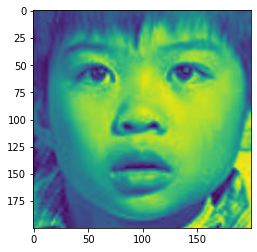

In [ ]:
from skimage import io
import matplotlib.pyplot as plt
img = io.imread('./gdrive/MyDrive/Dataset/06-20/10_0_2_20170110224230094.jpg', as_gray=True)
plt.imshow(img) #Specify that it's in grayscale

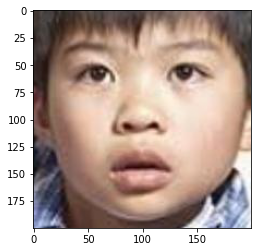

In [ ]:
img = plt.imread('./gdrive/MyDrive/Dataset/06-20/10_0_2_20170110224230094.jpg')
plt.imshow(img/255, cmap = 'gray')

(200, 200)

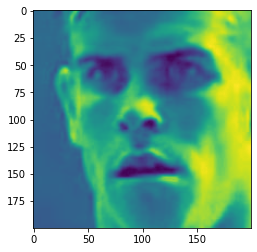

In [ ]:
from PIL import Image
img = Image.open('./gdrive/MyDrive/Dataset/25-30/25_0_0_20170104011300160.jpg').convert('L')
plt.imshow(img)
img.size

In [ ]:
import pandas as pd

df = pd.read_csv("./gdrive/MyDrive/images_grey.csv")
df.shape

(8457, 5)

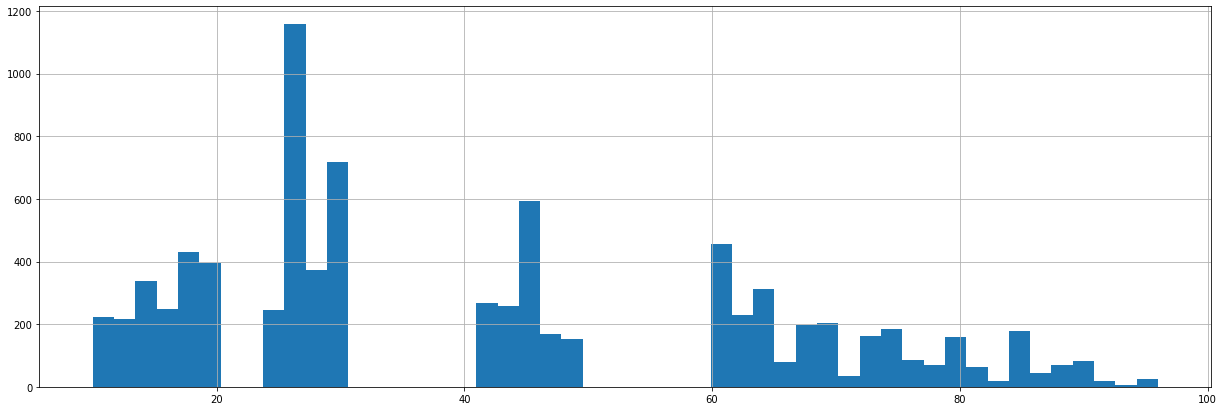

In [ ]:
df['Ages'].hist(bins=50, figsize=(21,7))
plt.show()

In [ ]:
df.head()

,Unnamed: 0,FilePath,Ages,AgeRange,GreyScaled
0,0,./gdrive/MyDrive/Dataset/60-98/60_1_0_20170120...,60,60-98,<PIL.Image.Image image mode=L size=200x200 at ...
1,1,./gdrive/MyDrive/Dataset/60-98/63_0_0_20170117...,63,60-98,<PIL.Image.Image image mode=L size=200x200 at ...
2,2,./gdrive/MyDrive/Dataset/60-98/75_1_1_20170105...,75,60-98,<PIL.Image.Image image mode=L size=200x200 at ...
3,3,./gdrive/MyDrive/Dataset/60-98/69_1_0_20170110...,69,60-98,<PIL.Image.Image image mode=L size=200x200 at ...
4,4,./gdrive/MyDrive/Dataset/60-98/77_0_2_20170112...,77,60-98,<PIL.Image.Image image mode=L size=200x200 at ...


We were worried that this type of grayscaling will not work with CNN so we wanted to try referenced grayscaling strategy to see if it would work.



#Grayscaling

In [ ]:
# Defining a function to read the image, decode the image from given tensor and one-hot encode the image label class.
# Changing the channels para in tf.io.decode_jpeg from 3 to 1 changes the output images from RGB coloured to grayscale.

num_classes = 7

def _parse_function(filename, label):
    
    image_string = tf.io.read_file(filename)
    image_decoded = tf.io.decode_jpeg(image_string, channels=1)    
    label = tf.one_hot(label, num_classes)

    return image_decoded, label

In [ ]:
# Classifying the age ranges for the age groups

def class_labels_reassign(age):

    if 1 <= age <= 2:
        return 0
    elif 3 <= age <= 9:
        return 1
    elif 10 <= age <= 20:
        return 2
    elif 21 <= age <= 27:
        return 3
    elif 28 <= age <= 45:
        return 4
    elif 46 <= age <= 65:
        return 5
    else:
        return 6

#Phase 1 Neural Network

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D, AveragePooling2D, GlobalAveragePooling2D, UpSampling2D, Dropout
from tensorflow.keras import utils
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

In [ ]:
shuffled = df.sample(frac=1, random_state=123).reset_index()

train_set = shuffled[:6000]
#train_set = shuffled[:1000]
test_set = shuffled[6000:]

In [ ]:
train_set['Labels'] = train_set['Ages'].map(class_labels_reassign)
test_set['Labels'] = test_set['Ages'].map(class_labels_reassign)

<ipython-input-52-3c52d2cf8d63>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set['Labels'] = train_set['Ages'].map(class_labels_reassign)
<ipython-input-52-3c52d2cf8d63>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['Labels'] = test_set['Ages'].map(class_labels_reassign)


In [ ]:
# Converting into a list

X_train_list = list(train_set['FilePath'])
y_train_list = list(train_set['Labels'])

X_test_list = list(test_set['FilePath'])
y_test_list = list(test_set['Labels'])

In [ ]:
# Converting into tensor

train_data = tf.data.Dataset.from_tensor_slices((X_train_list, y_train_list))
train_data = train_data.map(_parse_function).batch(128)

test_data = tf.data.Dataset.from_tensor_slices((X_test_list, y_test_list))
test_data = test_data.map(_parse_function).batch(128)

In [ ]:
# Defining the architecture of the sequential neural network.

final_cnn = Sequential()

# Input layer with 32 filters, followed by an AveragePooling2D layer.
final_cnn.add(Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(200, 200, 1)))    # 3rd dim = 1 for grayscale images.
final_cnn.add(AveragePooling2D(pool_size=(2,2)))

# Three Conv2D layers with filters increasing by a factor of 2 for every successive Conv2D layer.
final_cnn.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
final_cnn.add(AveragePooling2D(pool_size=(2,2)))

final_cnn.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
final_cnn.add(AveragePooling2D(pool_size=(2,2)))

final_cnn.add(Conv2D(filters=256, kernel_size=3, activation='relu'))
final_cnn.add(AveragePooling2D(pool_size=(2,2)))

final_cnn.add(Conv2D(filters=512, kernel_size=3, activation='relu'))
final_cnn.add(AveragePooling2D(pool_size=(2,2)))

final_cnn.add(Conv2D(filters=1024, kernel_size=3, activation='relu'))
final_cnn.add(AveragePooling2D(pool_size=(2,2)))

# A GlobalAveragePooling2D layer before going into Dense layers below.
# GlobalAveragePooling2D layer gives no. of outputs equal to no. of filters in last Conv2D layer above (256).
final_cnn.add(GlobalAveragePooling2D())

# One Dense layer with 132 nodes so as to taper down the no. of nodes from no. of outputs of GlobalAveragePooling2D layer above towards no. of nodes in output layer below (7).
final_cnn.add(Dense(132, activation='relu'))

# Output layer with 7 nodes (equal to the no. of classes).
final_cnn.add(Dense(7, activation='softmax'))

final_cnn.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 198, 198, 32)      320       
                                                                 
 average_pooling2d_36 (Avera  (None, 99, 99, 32)       0         
 gePooling2D)                                                    
                                                                 
 conv2d_37 (Conv2D)          (None, 97, 97, 64)        18496     
                                                                 
 average_pooling2d_37 (Avera  (None, 48, 48, 64)       0         
 gePooling2D)                                                    
                                                                 
 conv2d_38 (Conv2D)          (None, 46, 46, 128)       73856     
                                                                 
 average_pooling2d_38 (Avera  (None, 23, 23, 128)     

In [ ]:
# Compiling the above created CNN architecture.

final_cnn.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

In [ ]:
# Fitting the above created CNN model.

final_cnn_history = final_cnn.fit(train_data,
                                  batch_size=128,
                                  validation_data=test_data,
                                  epochs=50, shuffle=False)

Epoch 1/50
47/47 [==============================] - 10s 199ms/step - loss: 3.5394 - accuracy: 0.2315 - val_loss: 1.5858 - val_accuracy: 0.3329
Epoch 2/50
47/47 [==============================] - 10s 203ms/step - loss: 1.5499 - accuracy: 0.2883 - val_loss: 1.4506 - val_accuracy: 0.3635
Epoch 3/50
47/47 [==============================] - 9s 199ms/step - loss: 1.4347 - accuracy: 0.3578 - val_loss: 1.4123 - val_accuracy: 0.3744
Epoch 4/50
47/47 [==============================] - 9s 201ms/step - loss: 1.3988 - accuracy: 0.3795 - val_loss: 1.4165 - val_accuracy: 0.3903
Epoch 5/50
47/47 [==============================] - 9s 197ms/step - loss: 1.4227 - accuracy: 0.3695 - val_loss: 1.6898 - val_accuracy: 0.2409
Epoch 6/50
47/47 [==============================] - 9s 197ms/step - loss: 1.4121 - accuracy: 0.3715 - val_loss: 1.3561 - val_accuracy: 0.3972
Epoch 7/50
47/47 [==============================] - 9s 200ms/step - loss: 1.3369 - accuracy: 0.4153 - val_loss: 1.3190 - val_accuracy: 0.4164
Epoc

The original dataset that we used from Kaggle only had a 53% accuracy. The tutorial referenced was able to cap at around 90% accuracy. This made us believe that we did not have enough data to use CNN accurately.

#Phase 2 of Data Collection

In [ ]:
# Phase 2 of dataset collection and grayscaling 
import cv2
import os
from zipfile import ZipFile
import time
from datetime import datetime
import itertools

In [ ]:
# Unzipping the dataset file combined_faces.zip

combined_faces_zip_path = "./gdrive/MyDrive/combined_faces.zip"

with ZipFile(combined_faces_zip_path, 'r') as myzip:
    myzip.extractall()
    print('Done unzipping combined_faces.zip')

Done unzipping combined_faces.zip


In [ ]:
# Unzipping the dataset file augmented combined_faces.zip

combined_faces_zip_path = "./gdrive/MyDrive/combined_faces_train_augmented.zip"

with ZipFile(combined_faces_zip_path, 'r') as myzip:
    myzip.extractall()
    print('Done unzipping combined_faces_train_augmented.zip')

Done unzipping combined_faces_train_augmented.zip


In [ ]:
# Importing the augmented training dataset and testing dataset to create tensors of images using the filename paths.
import pandas as pd
train_aug_df = pd.read_csv("./gdrive/MyDrive/images_filenames_labels_train_augmented.csv")
test_df = pd.read_csv("./gdrive/MyDrive/images_filenames_labels_test.csv")

In [ ]:
# Displaying an image from the file
import numpy as np
import matplotlib.pyplot as plt
import glob 

fpath = r'/content/content/combined_faces/8_163.jpg'
img = plt.imread(fpath)
plt.imshow(img)

# Referenced: https://www.youtube.com/watch?v=oDIpOJFSuOA AND https://sparkbyexamples.com/pandas/pandas-read-multiple-csv-files/

In [ ]:
test_df.shape

(10046, 2)

Unzipping files in Google Colab is faster than unzipping locally and loading the data.

#Classification of Ages

In [ ]:
# Classifying the age ranges for the age groups

def class_labels_reassign(age):

    if 1 <= age <= 2:
        return 0
    elif 3 <= age <= 9:
        return 1
    elif 10 <= age <= 20:
        return 2
    elif 21 <= age <= 27:
        return 3
    elif 28 <= age <= 45:
        return 4
    elif 46 <= age <= 65:
        return 5
    else:
        return 6

In [ ]:
train_aug_df['Labels'] = train_aug_df['age'].map(class_labels_reassign)
test_df['Labels'] = test_df['age'].map(class_labels_reassign)

In [ ]:
test_df.head()

,filename,age,Labels
0,/content/content/combined_faces/8_163.jpg,8,1
1,/content/content/combined_faces/38_66.jpg,38,4
2,/content/content/combined_faces/40_177.jpg,40,4
3,/content/content/combined_faces/36_267.jpg,36,4
4,/content/content/combined_faces/8_349.jpg,8,1


#Phase 2 Neural Network

##Grayscaling

In [ ]:
# Defining a function to read the image, decode the image from given tensor and one-hot encode the image label class.
# Changing the channels para in tf.io.decode_jpeg from 3 to 1 changes the output images from RGB coloured to grayscale.

num_classes = 7

def _parse_function(filename, label):
    
    image_string = tf.io.read_file(filename)
    image_decoded = tf.io.decode_jpeg(image_string, channels=1)    
    label = tf.one_hot(label, num_classes)

    return image_decoded, label

In [ ]:
# Converting into tensor

train_data = tf.data.Dataset.from_tensor_slices((X_train_list, y_train_list))
train_data = train_data.map(_parse_function).batch(128)

test_data = tf.data.Dataset.from_tensor_slices((X_test_list, y_test_list))
test_data = test_data.map(_parse_function).batch(128)

In [ ]:
# Defining the architecture of the sequential neural network.

final_cnn = Sequential()

# Input layer with 32 filters, followed by an AveragePooling2D layer.
final_cnn.add(Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(200, 200, 1)))    # 3rd dim = 1 for grayscale images.
final_cnn.add(AveragePooling2D(pool_size=(2,2)))

# Three Conv2D layers with filters increasing by a factor of 2 for every successive Conv2D layer.
final_cnn.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
final_cnn.add(AveragePooling2D(pool_size=(2,2)))

final_cnn.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
final_cnn.add(AveragePooling2D(pool_size=(2,2)))

final_cnn.add(Conv2D(filters=256, kernel_size=3, activation='relu'))
final_cnn.add(AveragePooling2D(pool_size=(2,2)))

final_cnn.add(Conv2D(filters=512, kernel_size=3, activation='relu'))
final_cnn.add(AveragePooling2D(pool_size=(2,2)))

final_cnn.add(Conv2D(filters=1024, kernel_size=3, activation='relu'))
final_cnn.add(AveragePooling2D(pool_size=(2,2)))

# A GlobalAveragePooling2D layer before going into Dense layers below.
# GlobalAveragePooling2D layer gives no. of outputs equal to no. of filters in last Conv2D layer above (256).
final_cnn.add(GlobalAveragePooling2D())

# One Dense layer with 132 nodes so as to taper down the no. of nodes from no. of outputs of GlobalAveragePooling2D layer above towards no. of nodes in output layer below (7).
final_cnn.add(Dense(132, activation='relu'))

final_cnn.add(Dropout(0.3))

# Output layer with 7 nodes (equal to the no. of classes).
final_cnn.add(Dense(7, activation='softmax'))

final_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 198, 198, 32)      320       
                                                                 
 average_pooling2d_6 (Averag  (None, 99, 99, 32)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_7 (Conv2D)           (None, 97, 97, 64)        18496     
                                                                 
 average_pooling2d_7 (Averag  (None, 48, 48, 64)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_8 (Conv2D)           (None, 46, 46, 128)       73856     
                                                                 
 average_pooling2d_8 (Averag  (None, 23, 23, 128)     

In [ ]:
# Compiling the above created CNN architecture.

final_cnn.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping

# use tensorboard to view metrics
tensorboard = TensorBoard(log_dir="logs")
# define early stopping to stop training after 5 epochs of not improving
early_stopping = EarlyStopping(mode="min", patience=5, restore_best_weights=True)


In [ ]:
# Fitting the above created CNN model.

final_cnn_history = final_cnn.fit(train_data,
                                  batch_size=128,
                                  validation_data=test_data,
                                  epochs=50, shuffle=False)

Epoch 1/50
1832/1832 [==============================] - 56s 30ms/step - loss: 1.5012 - accuracy: 0.3962 - val_loss: 1.2241 - val_accuracy: 0.4921
Epoch 2/50
1832/1832 [==============================] - 55s 30ms/step - loss: 1.1827 - accuracy: 0.5112 - val_loss: 1.0566 - val_accuracy: 0.5542
Epoch 3/50
1832/1832 [==============================] - 55s 30ms/step - loss: 1.0707 - accuracy: 0.5543 - val_loss: 1.0536 - val_accuracy: 0.5467
Epoch 4/50
1832/1832 [==============================] - 55s 30ms/step - loss: 0.9973 - accuracy: 0.5811 - val_loss: 0.9199 - val_accuracy: 0.6101
Epoch 5/50
1832/1832 [==============================] - 55s 30ms/step - loss: 0.9399 - accuracy: 0.6025 - val_loss: 0.8644 - val_accuracy: 0.6344
Epoch 6/50
1832/1832 [==============================] - 55s 30ms/step - loss: 0.8941 - accuracy: 0.6206 - val_loss: 0.8337 - val_accuracy: 0.6465
Epoch 7/50
1832/1832 [==============================] - 55s 30ms/step - loss: 0.8515 - accuracy: 0.6379 - val_loss: 0.7969 -

Our accuracy is a lot better with augmented data and more layers. 

##Performance

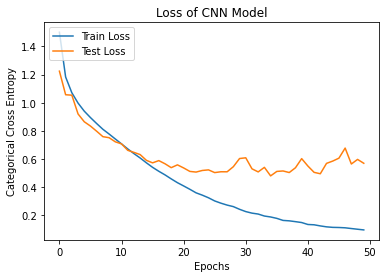

In [ ]:
import matplotlib.pyplot as plt

plt.plot(final_cnn_history.history['loss'])
plt.plot(final_cnn_history.history['val_loss'])
plt.title("Loss of CNN Model")
plt.xlabel("Epochs")
plt.ylabel("Categorical Cross Entropy")
plt.legend(['Train Loss', 'Test Loss'], loc='upper left')
plt.show()

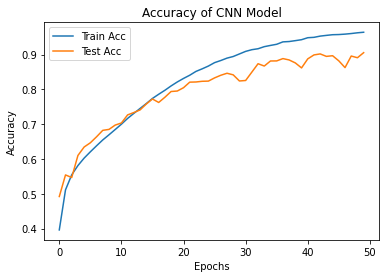

In [ ]:
plt.plot(final_cnn_history.history['accuracy'])
plt.plot(final_cnn_history.history['val_accuracy'])
plt.title("Accuracy of CNN Model")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(['Train Acc', 'Test Acc'], loc='upper left')
plt.show()

#Predictions

In [ ]:
final_cnn_pred = final_cnn.predict(test_data)
final_cnn_pred = final_cnn_pred.argmax(axis=-1)

79/79 [==============================] - 1s 18ms/step


In [ ]:
final_cnn_pred.size

10046

In [ ]:
class_labels = {0:'1-2', 1:'3-9', 2:'10-20', 3:'21-27', 4:'28-45', 5:'46-65', 6:'66-116'}
final = []

for i in range(final_cnn_pred.size):
  final.append(class_labels[final_cnn_pred[i]])


In [ ]:
pd.DataFrame(final, columns=['AgePredictions']).to_csv('AgePredictions.csv', index=False)
from google.colab import files
files.download("AgePredictions.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd

df = pd.read_csv("./gdrive/MyDrive/AgePredictions.csv")
df.shape

(10046, 1)

In [ ]:
df['AgePredictions'][10000]

'46-65'

In [ ]:
test_df['age'][10000]

85

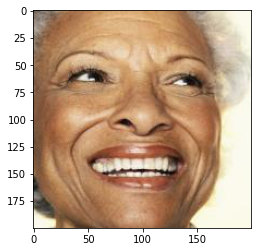

In [ ]:
import numpy as np
import matplotlib.pyplot as plt4
import glob 

fpath = test_df['filename'][10000]
img = plt.imread(fpath)
plt.imshow(img)